In [111]:
import warnings
import math
import datetime
import time
import itertools

import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### **Import Data DRIAS-CLIMAT** 
- Production : eurocordex2020
- Modele : CNRM-ALADIN63 - CNRM-CERFACS-CNRM-CM5 (RCM - GCM)
- Scenario : rcp4.5 / rcp2.5
- Donnees CORRIGEES
- Periode : 01/01/2006 - 31/12/2100
    1. <span style="color: #7369FFFF;">Format de la ligne</span>  : "Date Latitude Longitude  tasminAdjust tasmaxAdjust tasAdjust prtotAdjust prsnAdjust
    2. <span style="color: #7369FFFF;">Date</span> : Date du jour sous la forme 'JJ/MM/AAAA'
    3. <span style="color: #7369FFFF;">Latitude Longitude</span> : position du point de grille SAFRAN en degres decimaux (WGS84)
    4. <span style="color: #7369FFFF;">tasminAdjust</span> : Temperature minimale journaliere a 2 m [K]
    5. <span style="color: #7369FFFF;">tasmaxAdjust</span> : Temperature maximale journaliere a 2 m [K]
    6. <span style="color: #7369FFFF;">tasAdjust</span> : Temperature moyenne a 2 m [K]
    7. <span style="color: #7369FFFF;">prtotAdjust</span> : Precipitations totales [kg/m2/s]
    8. <span style="color: #7369FFFF;">prsnAdjust</span> : Precipitations solides [kg/m2/s]
    9. <span style="color: #7369FFFF;">hussAdjust</span> : Humidite specifique a 2 m [kg/kg]
    10. <span style="color: #7369FFFF;">rsdsAdjust</span> : Rayonnement visible incident a la surface [W/m2]
    11. <span style="color: #7369FFFF;">rldsAdjust</span> : Rayonnement infra-rouge incident a la surface [W/m2]
    12. <span style="color: #7369FFFF;">sfcWindAdjust</span> : Vitesse du vent a 10 m [m/s]
    13. <span style="color: #7369FFFF;">evspsblpotAdjust</span> : Evapo-transpiration potentielle Hargreaves [kg/m2/s]

In [ ]:
data_rcp_4_5 = pd.read_excel('CNRM-CERFACS-CNRM-CM5_CNRM-ALADIN63_rcp4.5_METEO-FRANCE_ADAMONT-France_SAFRAN_day_2006_2100.xlsx')
data_rcp_4_5['Date'] = pd.to_datetime(data_rcp_4_5['Date'], format='%d/%m/%Y')
data_rcp_4_5.set_index('Date', inplace=True)
data_rcp_4_5.head()     

,Latitude,Longitude,tasminAdjust,tasmaxAdjust,tasAdjust,prtotAdjust,prsnAdjust,hussAdjust,rsdsAdjust,rldsAdjust,sfcWindAdjust,evspsblpotAdjust
Date,,,,,,,,,,,,
2006-01-01,49.2427,4.03882,270.00,277.80,273.13,0.000003,0.000003,0.003503,53.157,264.926,2.138,1.800000e-06
2006-01-02,49.2427,4.03882,273.19,277.21,275.18,0.000097,0.000012,0.005015,9.143,347.306,7.012,5.000000e-07
2006-01-03,49.2427,4.03882,281.74,282.12,281.97,0.000008,0.000000,0.008196,8.756,381.686,8.374,2.000000e-06
2006-01-04,49.2427,4.03882,282.91,286.21,285.07,0.000001,0.000000,0.007773,16.775,355.457,5.803,5.500000e-06
2006-01-05,49.2427,4.03882,278.30,284.15,280.35,0.000000,0.000000,0.006088,29.116,337.960,1.557,2.200000e-06


In [36]:
data_rcp_2_6 = pd.read_excel('CNRM-CERFACS-CNRM-CM5_CNRM-ALADIN63_rcp2.6_METEO-FRANCE_ADAMONT-France_SAFRAN_day_2006_2100.xlsx')
data_rcp_2_6['Date'] = pd.to_datetime(data_rcp_2_6['Date'], format='%d/%m/%Y')
data_rcp_2_6.set_index('Date', inplace=True)
data_rcp_2_6.head()

,Latitude,Longitude,tasminAdjust,tasmaxAdjust,tasAdjust,prtotAdjust,prsnAdjust,hussAdjust,rsdsAdjust,rldsAdjust,sfcWindAdjust,evspsblpotAdjust
Date,,,,,,,,,,,,
2006-01-01,49.2427,4.03882,270.00,277.74,273.11,0.000000,0.000000,0.003508,53.716,265.013,2.181,1.800000e-06
2006-01-02,49.2427,4.03882,273.39,277.19,275.27,0.000102,0.000011,0.004973,9.241,344.004,7.124,6.000000e-07
2006-01-03,49.2427,4.03882,281.72,282.36,282.11,0.000009,0.000000,0.008280,7.535,382.930,8.292,1.800000e-06
2006-01-04,49.2427,4.03882,283.02,287.32,285.83,0.000005,0.000000,0.008134,19.244,356.590,5.446,5.000000e-06
2006-01-05,49.2427,4.03882,280.74,284.66,282.11,0.000000,0.000000,0.006754,14.233,367.906,2.020,3.400000e-06


In [37]:
# Conversion température de Kelvin (K) en Celsius (°C) 
data_rcp_4_5['tasminAdjust'] = data_rcp_4_5['tasminAdjust'] - 273.15
data_rcp_4_5['tasmaxAdjust'] = data_rcp_4_5['tasmaxAdjust'] - 273.15
data_rcp_4_5['tasAdjust'] = data_rcp_4_5['tasAdjust'] - 273.15
data_rcp_4_5.head()

,Latitude,Longitude,tasminAdjust,tasmaxAdjust,tasAdjust,prtotAdjust,prsnAdjust,hussAdjust,rsdsAdjust,rldsAdjust,sfcWindAdjust,evspsblpotAdjust
Date,,,,,,,,,,,,
2006-01-01,49.2427,4.03882,-3.15,4.65,-0.02,0.000003,0.000003,0.003503,53.157,264.926,2.138,1.800000e-06
2006-01-02,49.2427,4.03882,0.04,4.06,2.03,0.000097,0.000012,0.005015,9.143,347.306,7.012,5.000000e-07
2006-01-03,49.2427,4.03882,8.59,8.97,8.82,0.000008,0.000000,0.008196,8.756,381.686,8.374,2.000000e-06
2006-01-04,49.2427,4.03882,9.76,13.06,11.92,0.000001,0.000000,0.007773,16.775,355.457,5.803,5.500000e-06
2006-01-05,49.2427,4.03882,5.15,11.00,7.20,0.000000,0.000000,0.006088,29.116,337.960,1.557,2.200000e-06


In [38]:
# Conversion température de Kelvin (K) en Celsius (°C) 
data_rcp_2_6['tasminAdjust'] = data_rcp_2_6['tasminAdjust'] - 273.15
data_rcp_2_6['tasmaxAdjust'] = data_rcp_2_6['tasmaxAdjust'] - 273.15
data_rcp_2_6['tasAdjust'] = data_rcp_2_6['tasAdjust'] - 273.15
data_rcp_2_6.head()

,Latitude,Longitude,tasminAdjust,tasmaxAdjust,tasAdjust,prtotAdjust,prsnAdjust,hussAdjust,rsdsAdjust,rldsAdjust,sfcWindAdjust,evspsblpotAdjust
Date,,,,,,,,,,,,
2006-01-01,49.2427,4.03882,-3.15,4.59,-0.04,0.000000,0.000000,0.003508,53.716,265.013,2.181,1.800000e-06
2006-01-02,49.2427,4.03882,0.24,4.04,2.12,0.000102,0.000011,0.004973,9.241,344.004,7.124,6.000000e-07
2006-01-03,49.2427,4.03882,8.57,9.21,8.96,0.000009,0.000000,0.008280,7.535,382.930,8.292,1.800000e-06
2006-01-04,49.2427,4.03882,9.87,14.17,12.68,0.000005,0.000000,0.008134,19.244,356.590,5.446,5.000000e-06
2006-01-05,49.2427,4.03882,7.59,11.51,8.96,0.000000,0.000000,0.006754,14.233,367.906,2.020,3.400000e-06


#### **Import Data Historique-Météo Reims 2009-2025**

#### 🌡️ Températures (en °C)

- MAX_TEMPERATURE_C : Température maximale observée pendant la journée.
- MIN_TEMPERATURE_C : Température minimale observée pendant la journée.
- TEMPERATURE_MORNING_C_6H : Température enregistrée à 6h du matin.
- TEMPERATURE_NOON_C_12H : Température enregistrée à midi (12h).
- TEMPERATURE_EVENING_C_18H : Température enregistrée à 18h.
- TEMPERATURE_NIGHT_C_3H : Température enregistrée à 3h du matin.
- TEMPERATURE_9H : Température enregistrée à 9h du matin.
- TEMPERATURE_15H : Température enregistrée à 15h.
- TEMPERATURE_21H : Température enregistrée à 21h.
- TEMPERATURE_MIDNIGHT_0H : Température enregistrée à minuit.

##### 🌬️ Vent

- WINDSPEED_MAX_KMH : Vitesse maximale du vent enregistrée pendant la journée (en km/h).
- WINDTEMP_MAX_C : Température ressentie à cause du vent (wind chill) maximale (en °C).

##### 💧 Humidité et précipitations

- HUMIDITY_MAX_PERCENT : Humidité relative maximale (%).
- PRECIP_TOTAL_DAY_MM : Total des précipitations journalières (en millimètres).
- TOTAL_SNOW_MM : Quantité totale de neige tombée dans la journée (en mm).
- DEWPOINT_MAX_C : Point de rosée maximum atteint dans la journée (en °C), indique la température à laquelle l’air devient saturé en humidité.

##### 🌫️ Autres conditions atmosphériques

- VISIBILITY_AVG_KM : Visibilité moyenne de la journée (en kilomètres).
- PRESSURE_MAX_MB : Pression atmosphérique maximale de la journée (en millibars).
- CLOUDCOVER_AVG_PERCENT : Couverture nuageuse moyenne de la journée (%).
- HEATINDEX_MAX_C : Indice de chaleur maximal (en °C), température ressentie en tenant compte de l'humidité.

##### 🌤️ Conditions météo codées (selon tranches horaires)

- WEATHER_CODE_MORNING_6H : Code météo à 6h du matin.
- WEATHER_CODE_NOON_12H : Code météo à 12h (midi).
- WEATHER_CODE_EVENING_18H : Code météo à 18h.
- WEATHER_CODE_NIGHT_3H : Code météo à 3h du matin.
- WEATHER_CODE_9H : Code météo à 9h.
- WEATHER_CODE_15H : Code météo à 15h.
- WEATHER_CODE_21H : Code météo à 21h.
- WEATHER_CODE_MIDNIGHT_0H : Code météo à minuit.

> 🔢 **Remarque :** Ces codes sont généralement des entiers représentant un type de météo (ex : 113 = ciel dégagé, 116 = partiellement nuageux, etc.).

##### ☀️ Rayonnement solaire

- UV_INDEX : Indice UV maximal de la journée.
- SUNHOUR : Nombre total d’heures d’ensoleillement dans la journée.
- SUNSET : Heure du coucher du soleil (format `HH:MM`).
- SUNRISE : Heure du lever du soleil (format `HH:MM`).

#####
 🧍 Opinion (subjective ou dérivée)

- OPINION : Évaluation subjective du temps de la journée (ex : "mauvais", "bon", "agréable", "caniculaire", etc.). Peut être dérivée à partir des autres données.

In [55]:
# Liste des années à importer
annees = range(2009, 2026)

# Liste pour stocker les DataFrames
dfs = []

# Boucle sur les années
for annee in annees:
    nom_fichier = f"export-reims{annee}.csv"
    df = pd.read_csv(nom_fichier, skiprows=3)
    dfs.append(df)

# Concatène tous les DataFrames en un seul
data_climate_reims_2009_2026 = pd.concat(dfs, ignore_index=True)

In [56]:
data_climate_reims_2009_2026['DATE'] = pd.to_datetime(data_climate_reims_2009_2026['DATE'], format='%Y-%m-%d')
data_climate_reims_2009_2026.set_index('DATE', inplace=True)
data_climate_reims_2009_2026.head()

,MAX_TEMPERATURE_C,MIN_TEMPERATURE_C,WINDSPEED_MAX_KMH,TEMPERATURE_MORNING_C_6H,TEMPERATURE_NOON_C_12H,TEMPERATURE_EVENING_C_18H,PRECIP_TOTAL_DAY_MM,HUMIDITY_MAX_PERCENT,VISIBILITY_AVG_KM,PRESSURE_MAX_MB,...,TEMPERATURE_NIGHT_C_3H,WEATHER_CODE_NIGHT_3H,TEMPERATURE_9H,WEATHER_CODE_9H,TEMPERATURE_15H,WEATHER_CODE_15H,TEMPERATURE_21H,WEATHER_CODE_21H,TEMPERATURE_MIDNIGHT_0H,WEATHER_CODE_MIDNIGHT_0H
DATE,,,,,,,,,,,,,,,,,,,,,
2009-01-01,3,-4,8,-3,3,-3,0.0,95,7.00,1029,...,-3,143,-2,113,0,116,-4,113,-3,143
2009-01-02,1,-5,15,-5,1,-2,0.0,88,10.00,1028,...,-5,113,-4,113,0,113,-2,116,-5,113
2009-01-03,1,-5,14,-4,1,-4,0.0,93,10.00,1028,...,-3,116,-3,113,-1,113,-5,113,-3,116
2009-01-04,-1,-6,8,-6,-1,-4,0.0,68,10.00,1026,...,-6,116,-5,113,-3,119,-4,116,-6,113
2009-01-05,-1,-4,10,-4,-1,-2,2.5,83,3.75,1021,...,-4,338,-3,332,-1,338,-2,332,-4,119


In [58]:
# MEAN_TEMPERATURE_C
colonnes_temp_horaires = [
    'TEMPERATURE_MORNING_C_6H',
    'TEMPERATURE_NOON_C_12H',
    'TEMPERATURE_EVENING_C_18H',
    'TEMPERATURE_NIGHT_C_3H',
    'TEMPERATURE_9H',
    'TEMPERATURE_15H',
    'TEMPERATURE_21H',
    'TEMPERATURE_MIDNIGHT_0H'
]

# Calcul de la moyenne journalière basée uniquement sur les températures horaires
data_climate_reims_2009_2026['MEAN_TEMPERATURE_C'] = data_climate_reims_2009_2026[colonnes_temp_horaires].mean(axis=1)
data_climate_reims_2009_2026['MEAN_TEMPERATURE_C']

DATE
2009-01-01    -1.875
2009-01-02    -2.750
2009-01-03    -2.750
2009-01-04    -4.375
2009-01-05    -2.625
               ...  
2025-04-26    11.875
2025-04-27    14.250
2025-04-28    14.500
2025-04-29    14.750
2025-04-30    15.750
Name: MEAN_TEMPERATURE_C, Length: 5964, dtype: float64

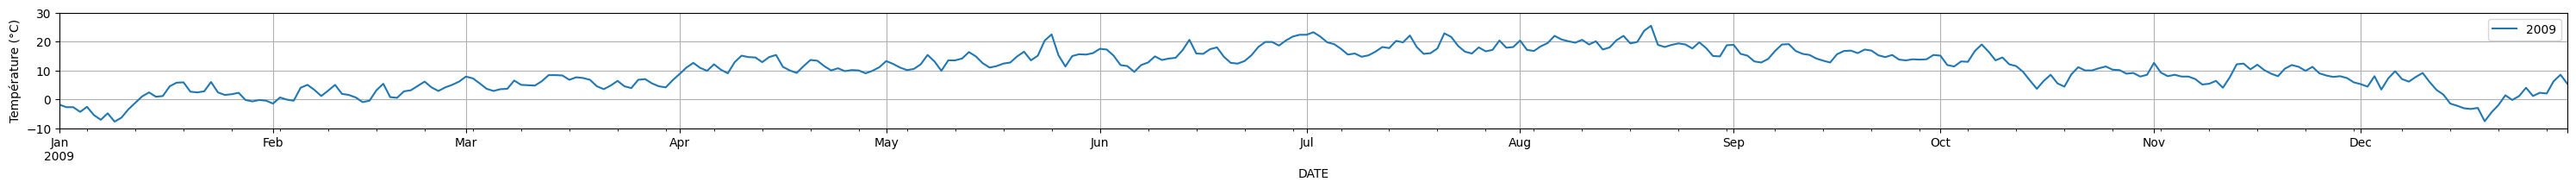

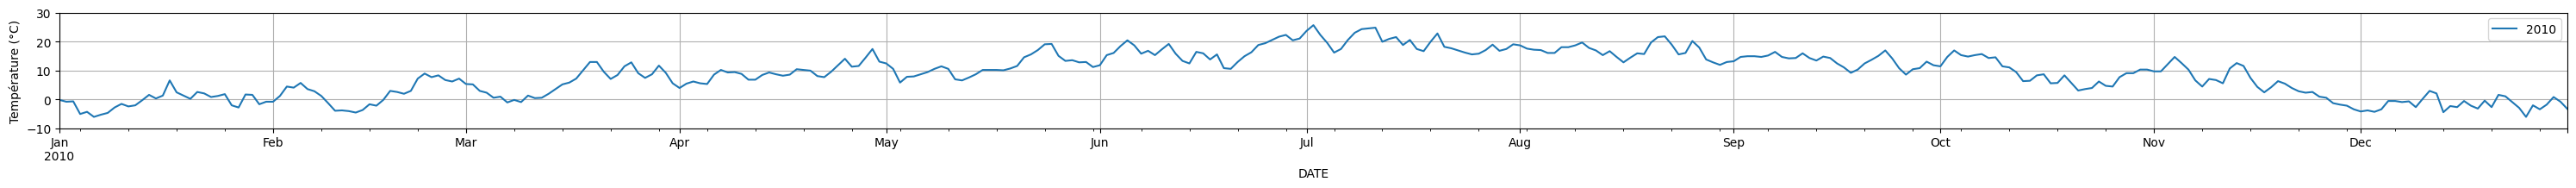

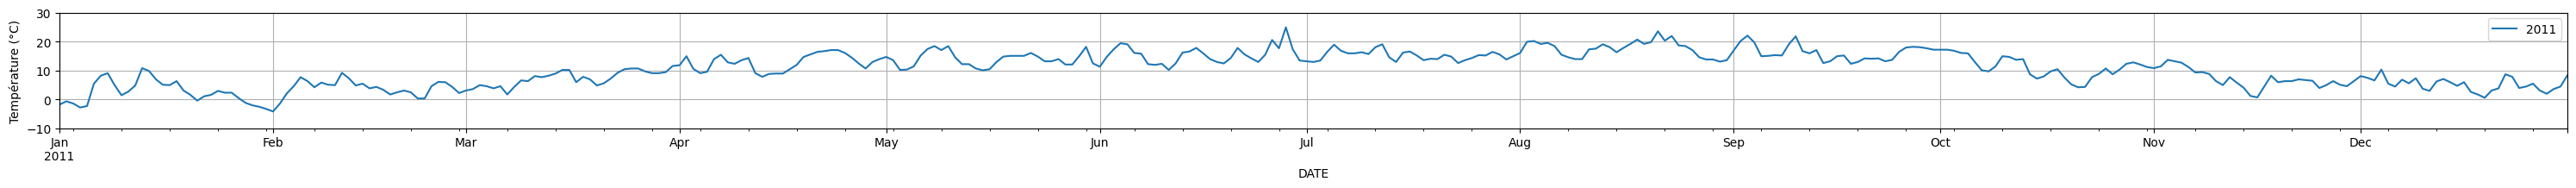

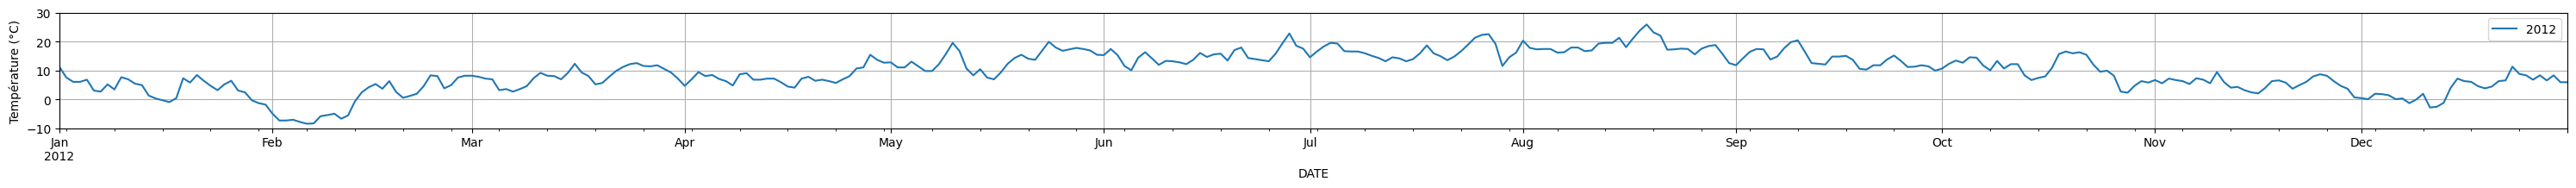

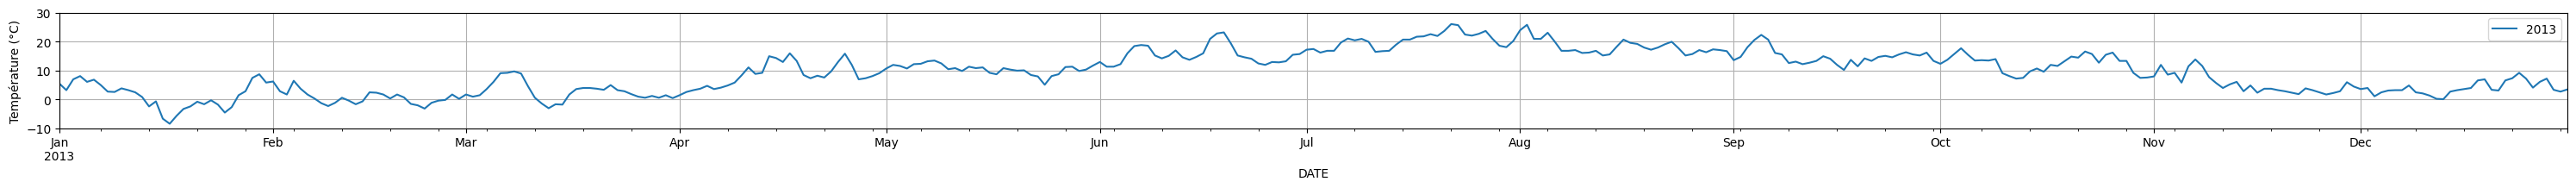

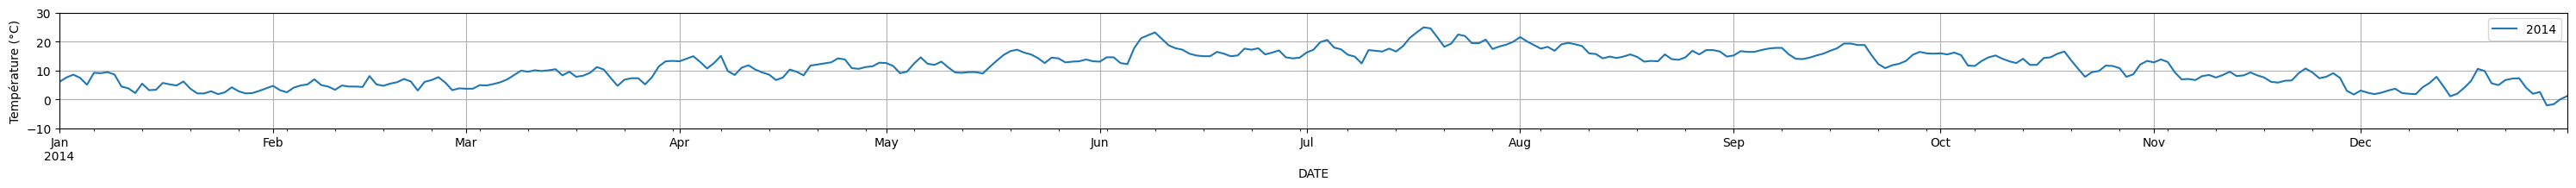

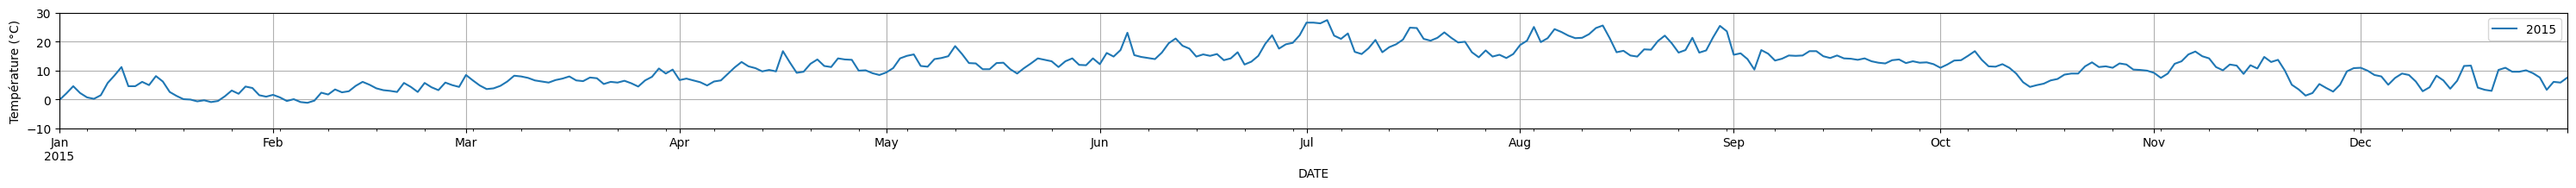

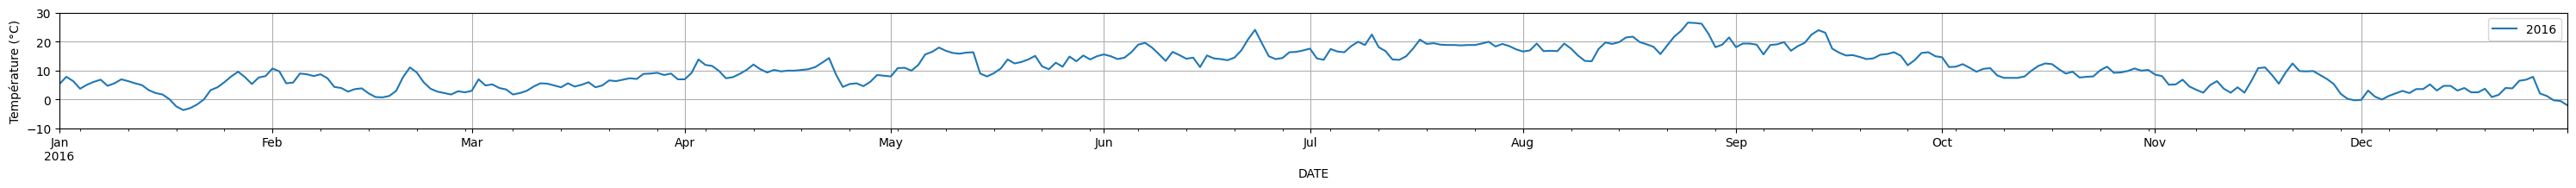

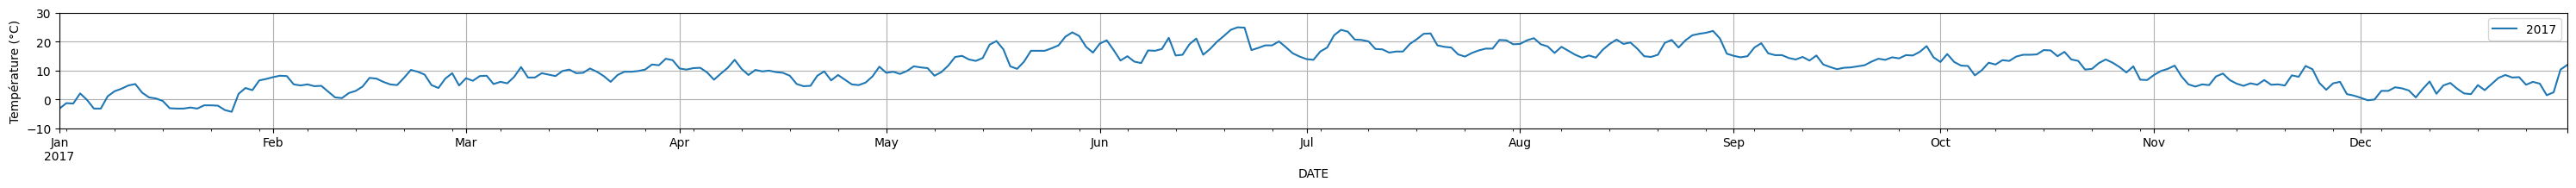

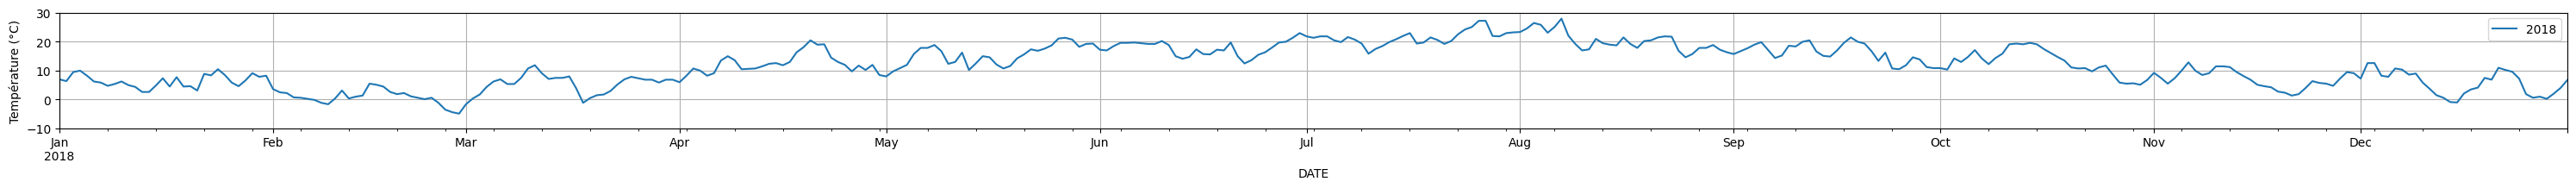

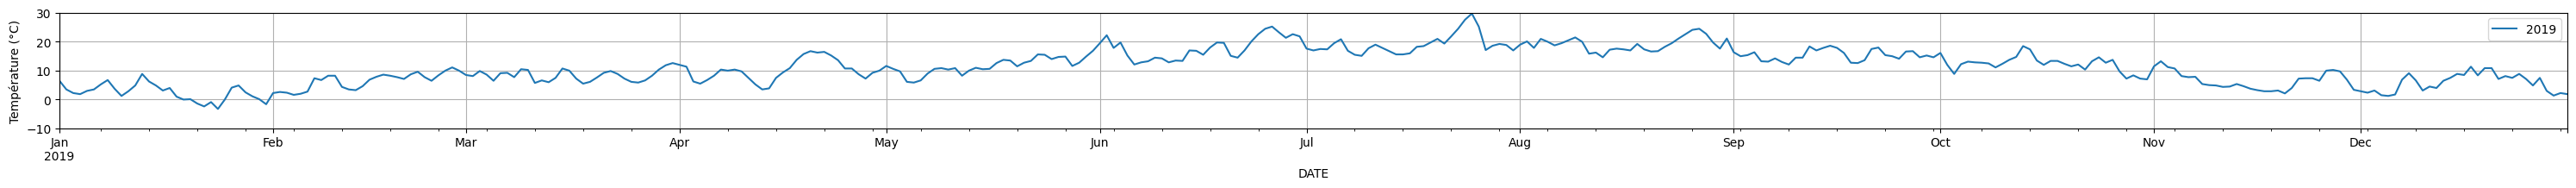

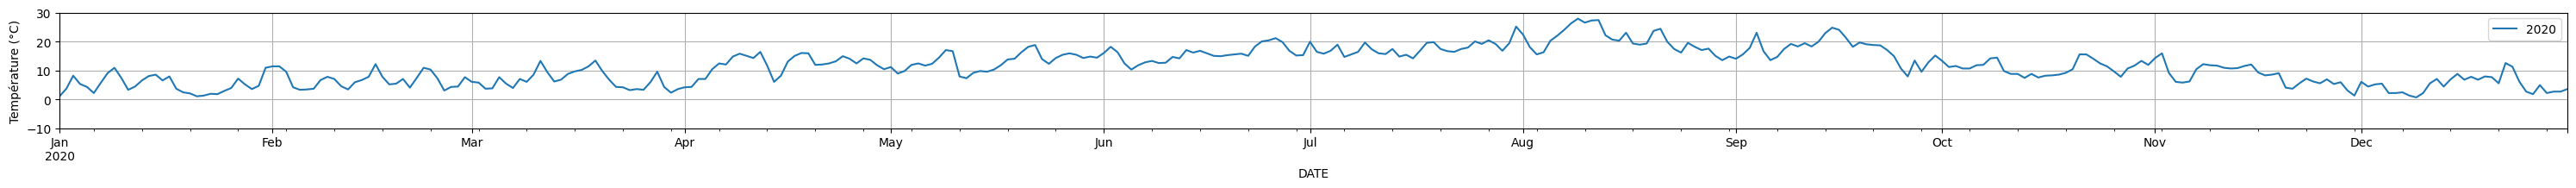

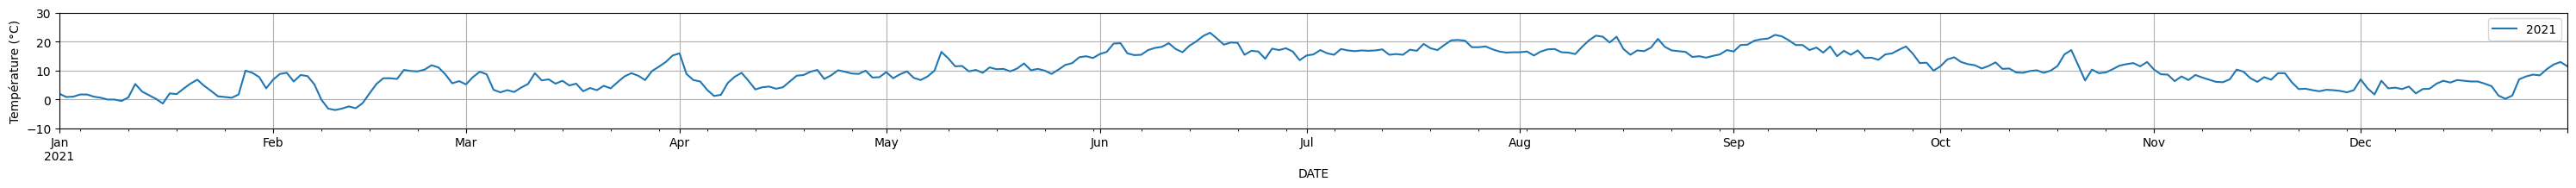

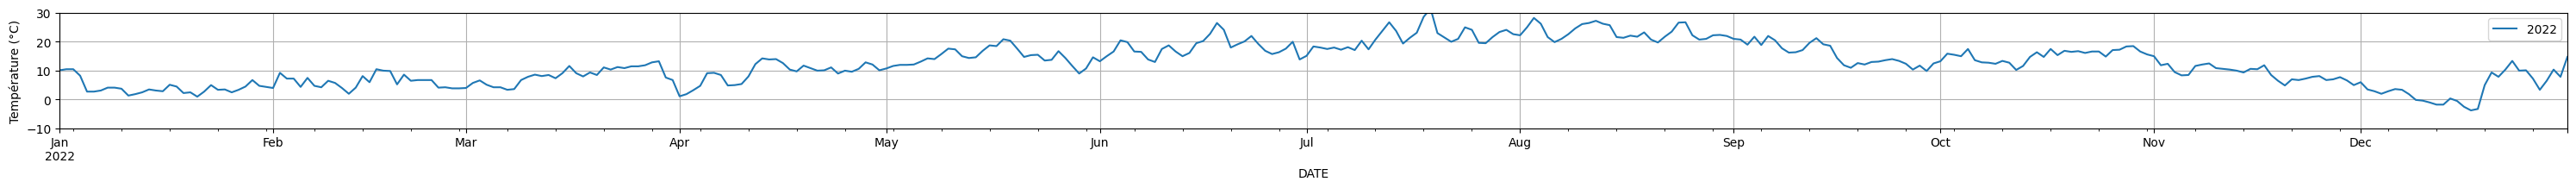

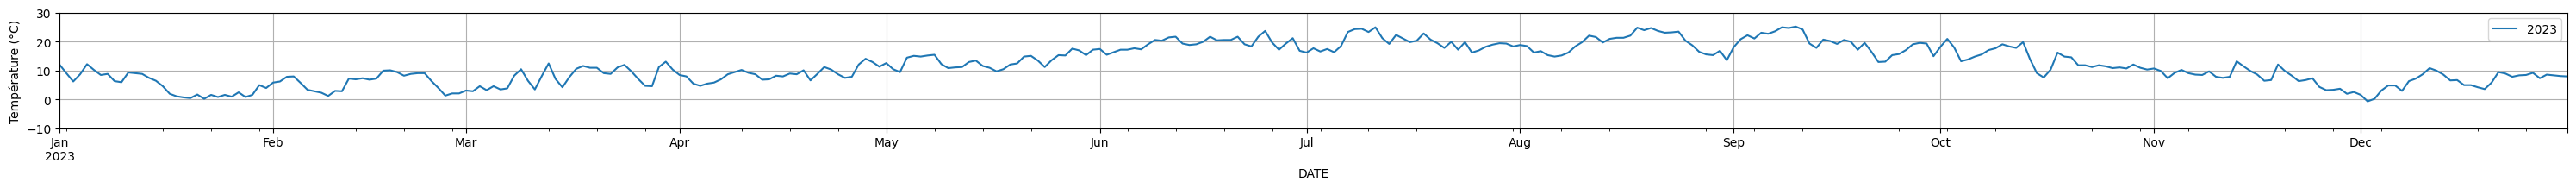

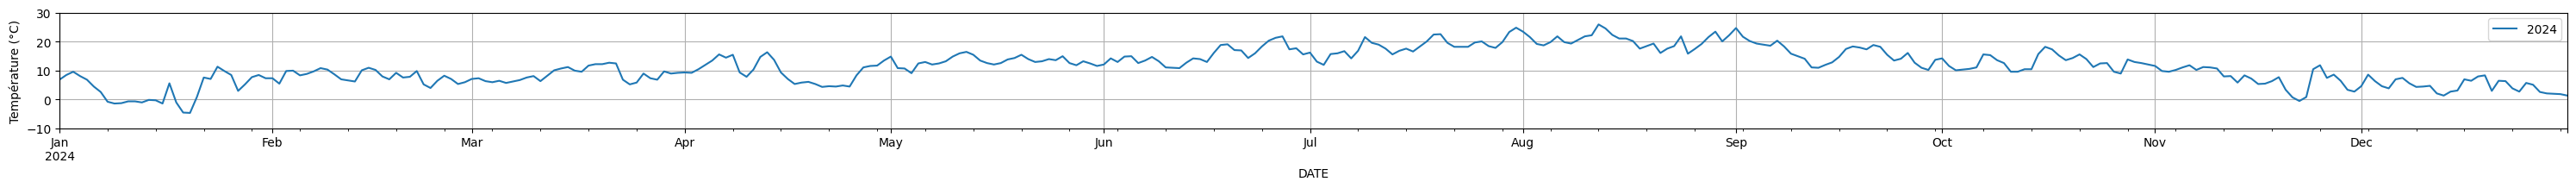

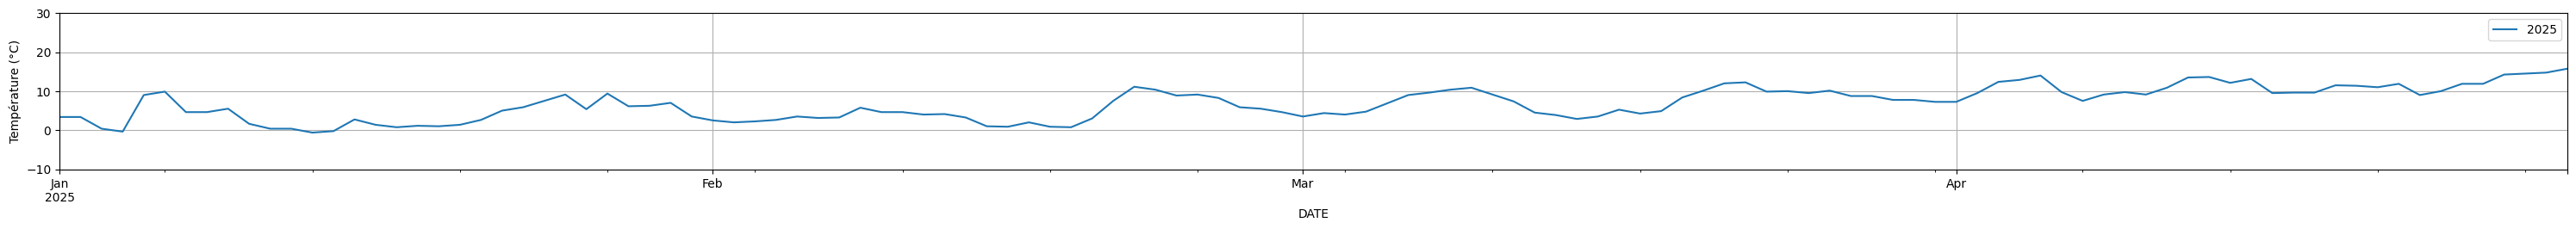

In [ ]:
# Liste des années à importer
annees = range(2009, 2026)

for i, annee in enumerate(annees, start=1):
    fig = plt.figure(figsize=(30, 35))
    ax1 = fig.add_subplot(len(annees), 1, i)

    # Filtrer les données pour l'année courante en utilisant l'index datetime
    df_annee = data_climate_reims_2009_2026[data_climate_reims_2009_2026.index.year == annee]

    # Tracer la courbe de température moyenne
    df_annee["MEAN_TEMPERATURE_C"].plot(ax=ax1, label=f"{annee}", color='tab:blue')
    # Détermine les bornes globales de température pour les graphiques (échelle uniforme)

    # Échelle orthonormée sur l'axe Y (identique pour tous les graphes)
    ax1.set_ylim(-10, 30)
    ax1.set_ylabel("Température (°C)", fontsize=10)
    ax1.grid(True)
    ax1.legend()

    plt.tight_layout()
    plt.show()

C:\Users\dvesa\AppData\Local\Temp\ipykernel_37104\2829748386.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(annees))


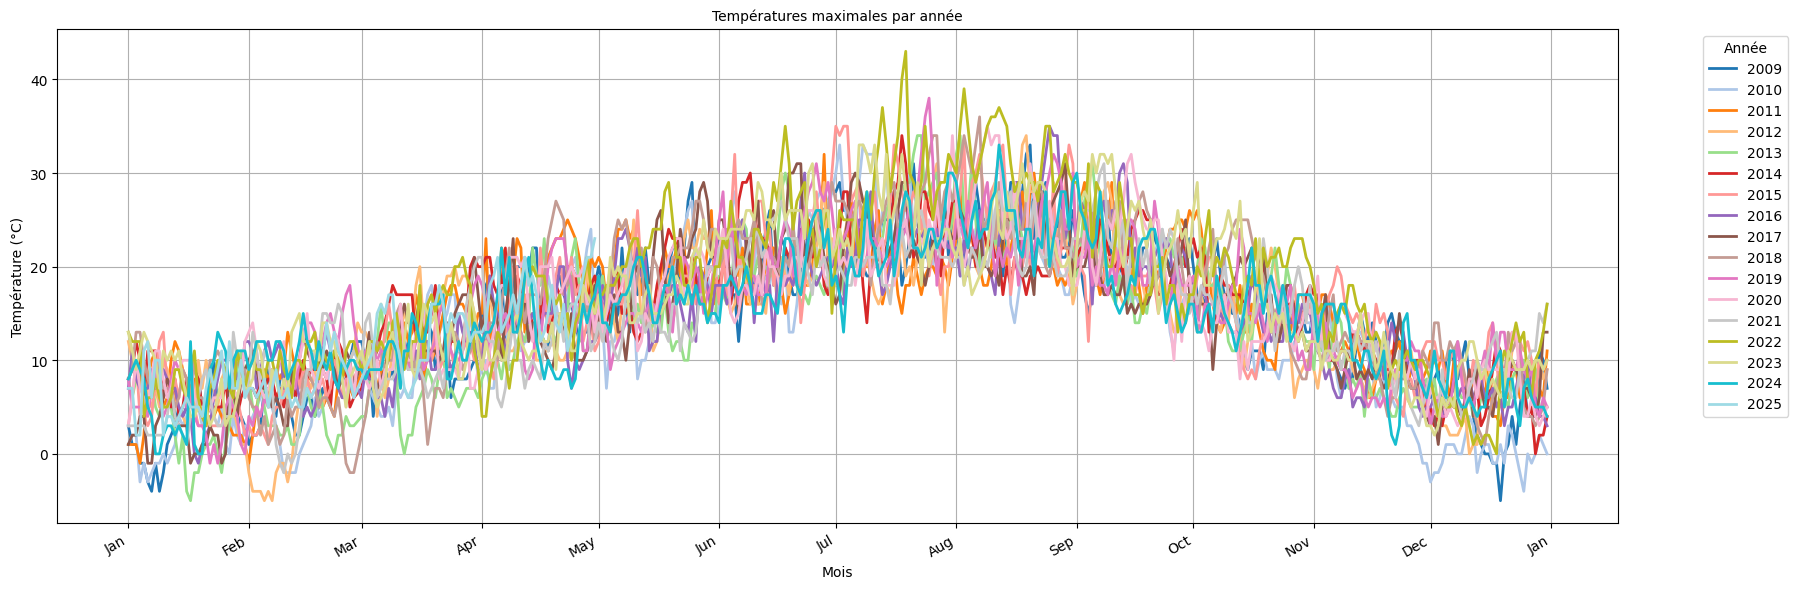

In [120]:
# Liste des années à importer
annees = range(2009, 2026)

# Initialiser la figure
plt.figure(figsize=(18, 6))

# Colormap pour couleurs différentes par année
colors = plt.cm.get_cmap('tab20', len(annees))

for idx, annee in enumerate(annees):
    # Filtrer les données de l'année
    df_annee = data_climate_reims_2009_2026[data_climate_reims_2009_2026.index.year == annee].copy()

    # Remplacer l'année dans les dates par 2000 pour superposition
    df_annee.index = df_annee.index.map(lambda d: d.replace(year=2000))

    # Tracer la température maximale avec une couleur unique par année
    df_annee["MAX_TEMPERATURE_C"].plot(
        label=str(annee),
        color=colors(idx),
        lw=2
    )

# Configuration de l'axe des X pour n’afficher que les mois
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # 'Jan', 'Feb', etc.

# Titre et labels
plt.title("Températures maximales par année", fontsize=10)
plt.xlabel("Mois")
plt.ylabel("Température (°C)")
plt.legend(title="Année", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\dvesa\AppData\Local\Temp\ipykernel_37104\3995001380.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(annees))


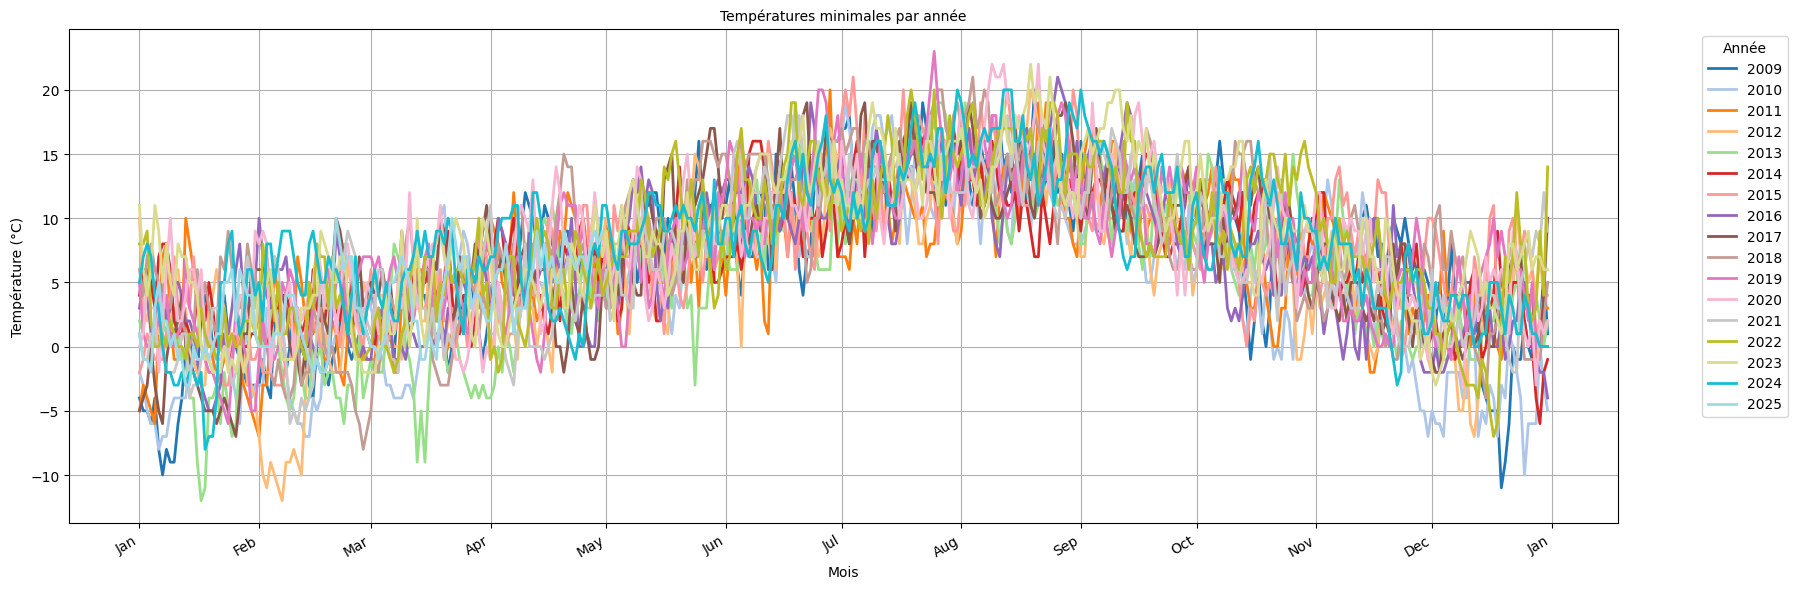

In [121]:
# Liste des années à importer
annees = range(2009, 2026)

# Initialiser la figure
plt.figure(figsize=(18, 6))

# Colormap pour couleurs différentes par année
colors = plt.cm.get_cmap('tab20', len(annees))

for idx, annee in enumerate(annees):
    # Filtrer les données de l'année
    df_annee = data_climate_reims_2009_2026[data_climate_reims_2009_2026.index.year == annee].copy()

    # Remplacer l'année dans les dates par 2000 pour superposition
    df_annee.index = df_annee.index.map(lambda d: d.replace(year=2000))

    # Tracer la température maximale avec une couleur unique par année
    df_annee["MIN_TEMPERATURE_C"].plot(
        label=str(annee),
        color=colors(idx),
        lw=2
    )

# Configuration de l'axe des X pour n’afficher que les mois
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # 'Jan', 'Feb', etc.

# Titre et labels
plt.title("Températures minimales par année", fontsize=10)
plt.xlabel("Mois")
plt.ylabel("Température (°C)")
plt.legend(title="Année", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\dvesa\AppData\Local\Temp\ipykernel_37104\3786489402.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(annees))


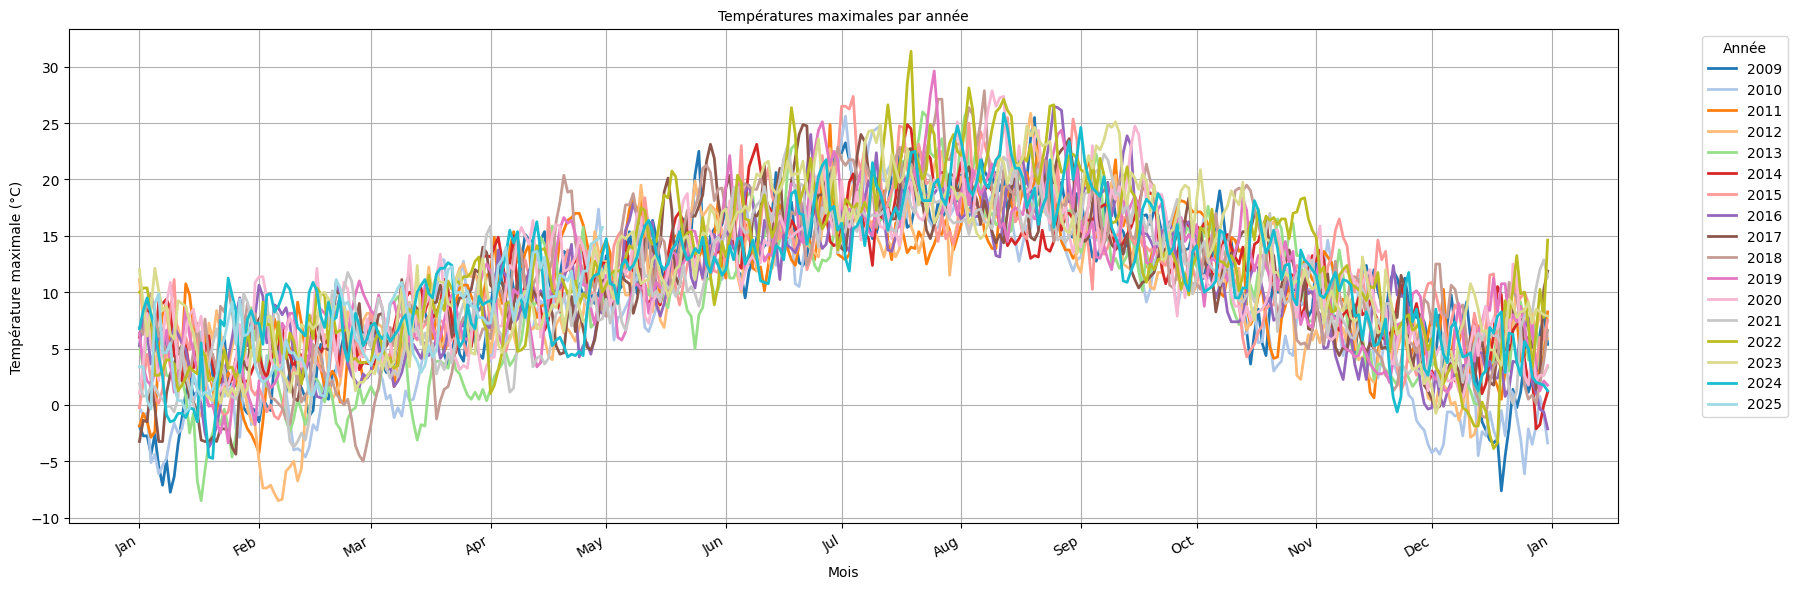

In [ ]:
# Liste des années à importer
annees = range(2009, 2026)

# Initialiser la figure
plt.figure(figsize=(18, 6))

# Colormap pour couleurs différentes par année
colors = plt.cm.get_cmap('tab20', len(annees))

for idx, annee in enumerate(annees):
    # Filtrer les données de l'année
    df_annee = data_climate_reims_2009_2026[data_climate_reims_2009_2026.index.year == annee].copy()

    # Remplacer l'année dans les dates par 2000 pour superposition
    df_annee.index = df_annee.index.map(lambda d: d.replace(year=2000))

    # Tracer la température maximale avec une couleur unique par année
    df_annee["MEAN_TEMPERATURE_C"].plot(
        label=str(annee),
        color=colors(idx),
        lw=2
    )

# Configuration de l'axe des X pour n’afficher que les mois
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # 'Jan', 'Feb', etc.

# Titre et labels
plt.title("Températures moyennes par année", fontsize=10)
plt.xlabel("Mois")
plt.ylabel("Température (°C)")
plt.legend(title="Année", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def temp_mean_std_min_max(data1, data2):
    """
    Affiche la distribution des données sous forme de box plot.

    Parameters:
    - data : list ou array-like
        Les données numériques à analyser.
    - bins : int (par défaut 30)
        Le nombre de barres pour l'histogramme.
    - titre : str
        Le titre du graphique.
    """
    
    # Liste des années à importer
    annees = range(2009, 2026)

    # Nombre de subplots nécessaires
    cols = 2  # Nombre de colonnes
    rows = len(annees) # Nombre de lignes

    i = 1
    
    #Initialiser le graphique
    plt.figure(figsize=(cols*14,rows*7))
    for idx, annee in enumerate(annees):
        
        plt.subplot(rows, cols, i)
        data1.loc["2018",j].resample('ME').mean().plot(label="Temp Moyenne par mois: 2018", lw=2)
        data.loc["2018",j].resample('ME').std().plot(label="Temp Écart type par mois: 2018", lw=2)
        data.loc["2018",j].resample('ME').min().plot(label="Temp Min par mois: 2018", lw=2)
        data.loc["2018",j].resample('ME').max().plot(label="Temp Max par mois: 2018", lw=2)
        plt.xlabel("")
        plt.ylabel("Temp")
        plt.title(f"{designations[j]} :{j}")
        plt.ylim(-10, 50)  # Limites pour l'axe Y
        plt.legend()
        plt.grid()
        plt.subplot(rows, cols, i+1)
        data.loc["2019",j].resample('ME').mean().plot(label="Temp Moyenne par mois: 2019", lw=2)
        data.loc["2019",j].resample('ME').std().plot(label="Temp Écart type par mois: 2019", lw=2)
        data.loc["2019",j].resample('ME').min().plot(label="Temp Min par mois: 2019", lw=2)
        data.loc["2019",j].resample('ME').max().plot(label="Temp Max par mois: 2019", lw=2)
        plt.xlabel("")
        plt.ylabel("Temp")
        plt.title(f"{designations[j]} :{j}")
        plt.ylim(-10, 50)  # Limites pour l'axe Y
        plt.legend()
        plt.grid()

        i = i + 2
        
    # Afficher le graphique
    plt.show()
